In [5]:
import sys
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.optimize import minimize, Bounds

In [6]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

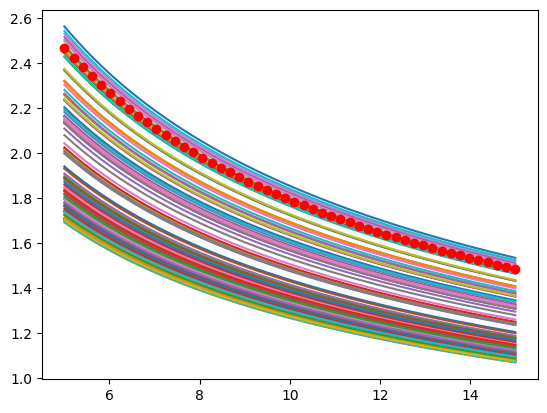

In [7]:
v = np.linspace(5, 15)

for i in range(100): plt.plot(v,v2dh_noised(v))
plt.plot(v, v2dh(v), 'ro')
plt.show()

In [8]:
x = np.linspace(0,100,100)
noise = np.random.rand(100)*100


here


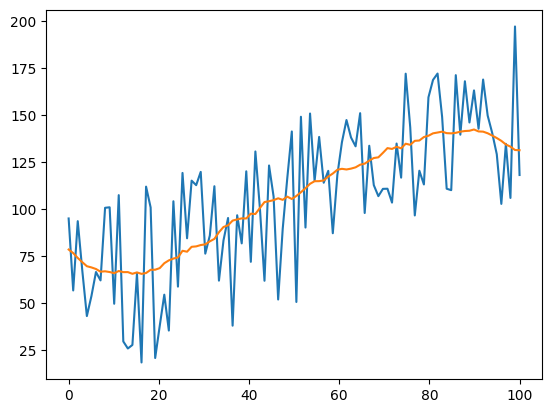

In [9]:
y = x+noise
y = savgol_filter(y, int(len(y)/2), 3, mode='nearest')

plt.plot(x,x+noise)
plt.plot(x,y)

print("here")
plt.show()

In [10]:
print("starting")
num_layers = 80
part_len = 50 #mm
v_min = 5
max_dH = v2dh(v_min)
v_max = 15
min_dH = v2dh(v_max)
points_per_layer = 100

layer_angle = np.arcsin((max_dH-min_dH)/part_len)
rot_point = max_dH/np.tan(layer_angle)-part_len/2
print(np.rad2deg(layer_angle))
print(rot_point)
print(max_dH)
print(min_dH)
print(np.rad2deg(num_layers*layer_angle))

starting
1.1257976619508032
100.6131657840027
2.468475190539253
1.4860946104132609
90.06381295606425


Final Height Error:  22.250145188109656


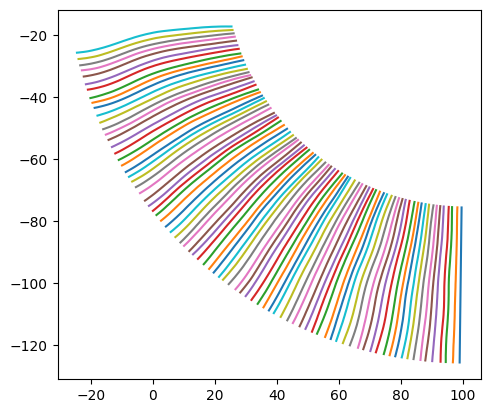

In [11]:


np.random.seed(1234)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)
for i in range(1,num_layers):
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_nom)+curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
print("Final Height Error: ", np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])))
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
plt.show()

In [12]:
def v_opt(v_next, v_prev, h_err, h_targ, lam):
    return norm(h_targ+h_err-v2dh(v_next), 2)**2

[ 5.          5.04379326  5.08814953  5.13307839  5.17858959  5.22469312
  5.27139915  5.3187181   5.36666059  5.41523748  5.46445986  5.51433907
  5.5648867   5.61611457  5.66803479  5.72065972  5.774002    5.82807457
  5.88289063  5.93846369  5.99480757  6.05193641  6.10986465  6.16860709
  6.22817885  6.2885954   6.34987259  6.41202661  6.47507406  6.53903192
  6.60391755  6.66974876  6.73654376  6.80432121  6.8731002   6.94290032
  7.0137416   7.08564457  7.15863028  7.23272028  7.30793667  7.38430209
  7.46183974  7.54057344  7.62052756  7.70172714  7.78419782  7.86796592
  7.95305844  8.03950306  8.12732822  8.21656305  8.30723751  8.39938229
  8.49302894  8.58820984  8.68495825  8.7833083   8.88329507  8.98495461
  9.08832392  9.19344106  9.30034512  9.4090763   9.5196759   9.63218642
  9.74665155  9.8631162   9.9816266  10.10223031 10.22497625 10.34991478
 10.47709774 10.60657848 10.73841195 10.87265473 11.0093651  11.1486031
 11.29043059 11.43491131 11.58211098 11.73209733 11.

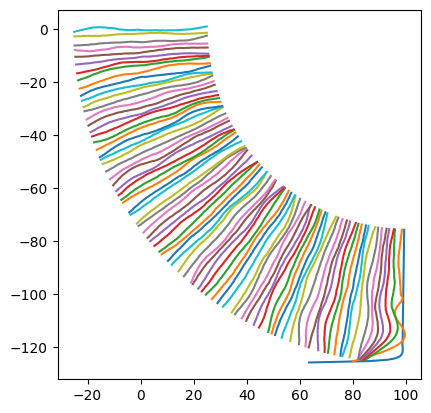

In [19]:
np.random.seed(1)

vel_prev = vel_nom
lam = 0.01
#constraints
bounds = Bounds(3, 17)

def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*5
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_profile = dh2v(height_profile)

print(vel_profile)
vel_profile = butter_lowpass_filter(vel_profile, 0.1, 1, 5)
print(vel_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_profile)
for i in range(1,num_layers):
    try:
        new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
        curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T

        # measure and correct
        height_vals_prev = curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]
        height_err = 0-height_vals_prev
        opt_result=minimize(v_opt, vel_nom, (vel_prev, height_err, height_profile, lam), bounds=bounds,
                            options = {'maxfun':100000})
        if not opt_result.success: 
            print(opt_result)
            raise ValueError(opt_result.message)
        vel_profile = opt_result.x
        print("Pre: ", vel_profile)
        vel_profile = savgol_filter(vel_profile, int(len(vel_profile)/2), 3, mode='nearest')
        print("Post", vel_profile)
        height_target = height_profile+height_err

        curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
        curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_profile)+height_vals_prev)

        vel_prev = vel_profile
    except:
        break
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
print("Final Height Error: ", np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])))
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
plt.show()